In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Make gif

In [32]:
import imageio
gif_path = '../logs/gifs/'
filenames = [gif_path + file for file in os.listdir(gif_path) if 'scheduler' in file]
epoch = [int(file.rstrip('.png').split('_')[-1]) for file in filenames]
sorted_filenames = [x for _, x in sorted(zip(epoch, filenames), key=lambda pair: pair[0])]
images = []
for filename in sorted_filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('../logs/sharpen_maps.gif', images)

# Post-processing

### Get predictions

In [3]:
plt.style.use('dark_background')
ordered_verts = ['T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'L1', 'L2', 'L3', 'L4']
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'orange', 'brown', 'pink', 'purple', 'm', 'gray', 'olive']

In [25]:
predictions = np.load('../outputs/kl_div_preds.npz')
ids, coords, dists, labels = predictions.values()

ids.shape, coords.shape, dists.shape, labels.shape

((46,), (46, 13), (46, 13, 512, 1), (46, 13))

### Get ground-truth data

In [26]:
def get_gt(id_):
    path = f'../data/testing/targets/'
    #image
    img_path = f'../data/testing/slices/sagittal/{id_}.npy'
    img = np.load(img_path)
    # Coordinates
    coord_path = path + f'coordinates/{id_}.csv'
    coords = pd.read_csv(coord_path)
    # Heatmaps
    dist_path = path + f'heatmaps/{id_}.npy'
    dists = np.load(dist_path)
    display(coords)
    return coords, dists, img

In [27]:
def plot_dist(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets, _ = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = dist[channel]
            ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


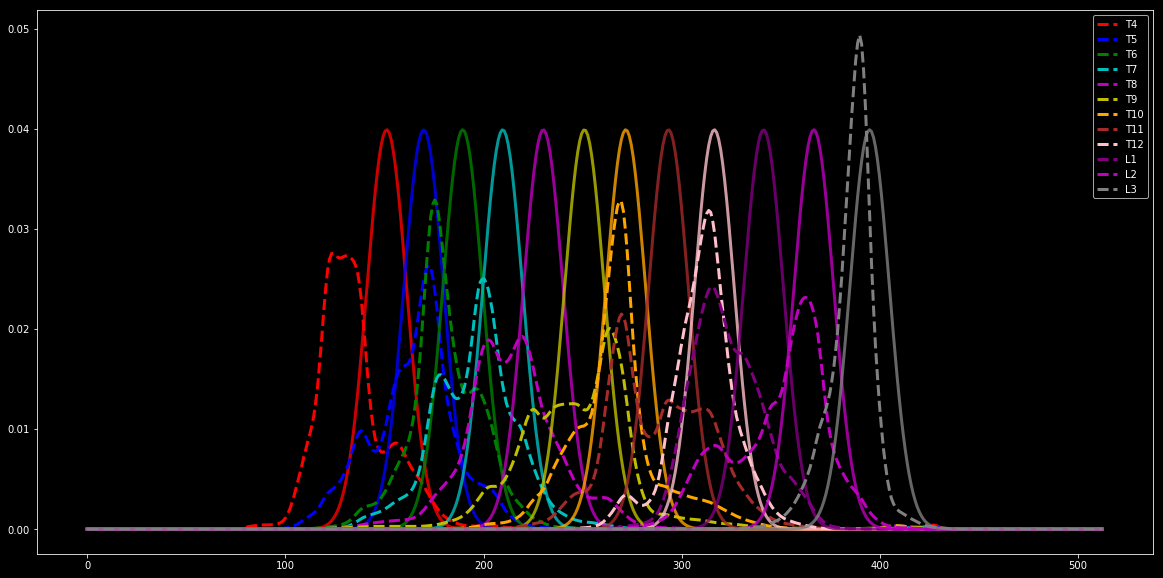

In [28]:
plot_dist(20)

In [8]:
def post(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets, _ = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    new_dist = np.zeros_like(dist)
    print(new_dist.shape)
    for pix in range(dist.shape[-1]):
        channel = np.argmax(dist[:, pix])
        new_dist[channel, pix] = np.max(dist[:, pix])
    
    print(new_dist.shape)
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = new_dist[channel]
            ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_553_LS_Sag


,Level,Coordinate
0,L4,240.605529
1,T11,127.974665
2,L1,169.362515
3,L2,188.007883
4,L3,212.837283
5,T12,150.888818


(13, 512)
(13, 512)


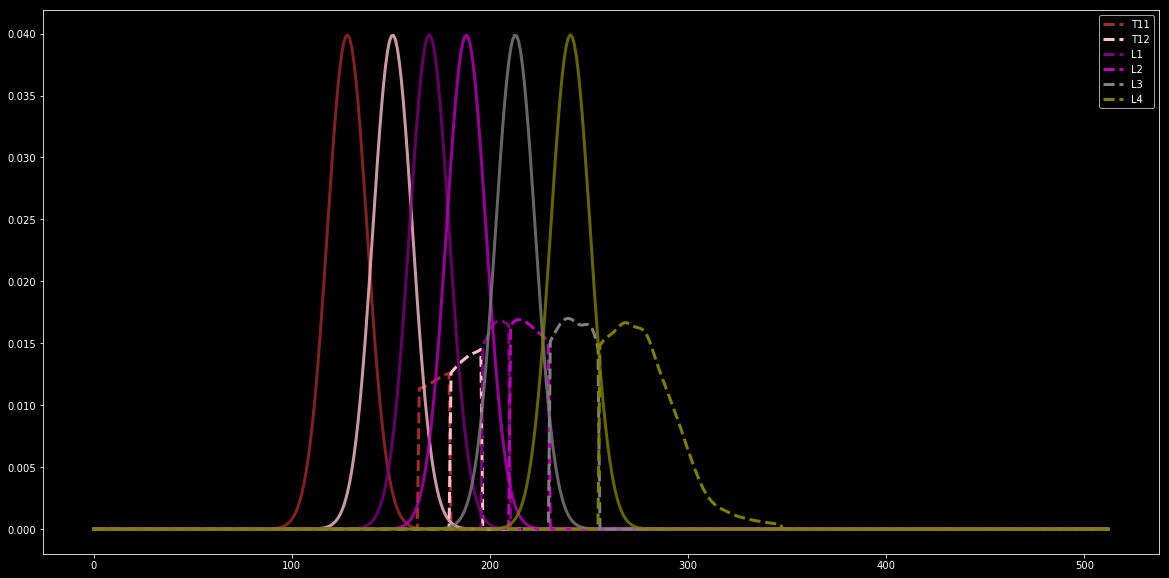

In [9]:
post(1)

In [10]:
from scipy.ndimage import zoom
import scipy.stats as ss

In [11]:
# ground-truth and prediction colormaps
g_cmap= sns.cubehelix_palette(start=0, rot=0, hue=1.5, gamma=1, as_cmap=True)
p_cmap = sns.cubehelix_palette(start=0.5, rot=-1., hue=1, gamma=1, as_cmap=True)

In [12]:
def plot_heatmap(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets, _ = get_gt(id_)
    
    #P = ss.multivariate_normal.fit(dist)
    #print(P)
    dist = zoom(input=dist, zoom=(10, 1), order=1)
    rand = np.random.rand(512, 130)
    gt_targets = zoom(input=gt_targets[:, 0], zoom=(1, 10), order=1)
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    
    ax[0].imshow(dist.T, cmap=p_cmap)
    ax[1].imshow(gt_targets, cmap=p_cmap)
    return dist

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


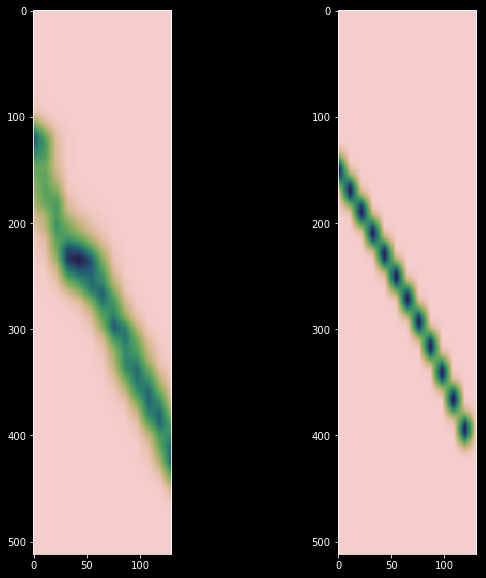

In [13]:
dist = plot_heatmap(20)

In [14]:
def js_reg(p, q):
    #~ Jensen-Shannon Divergence
    #@params:
    # *pred + target are 1D heatmaps
    assert p.shape == q.shape, 'Predicted heatmap not same shape as target'
    #* JS(P||Q) = 0.5*D(P||M) + 0.5*D(Q||M)
    #*M = 0.5*(P+Q)
    m = 0.5*(p + q)
    return 0.5*kl_reg(p, m) + 0.5*kl_reg(q, m)

def kl_reg(q, p):
    #~ Kullback-Leibler Divergence
    eps=1e-24
    #* D(P||Q) = P log P/Q 
    #* Add small constant to keep log finite
    unsummed_kl = p *(np.log((p+eps))- np.log((q+eps)))
    return unsummed_kl

In [15]:
def js_div(n):
    eps = 3e-28
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    _, gt_targets, _ = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.axhline(0, ls='--', c='k')
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            data = dist[channel]
            js_div = kl_reg(tgt, data)
            
            ax.plot(x, js_div, lw=3, color=colors[channel], label=vert)
#             ax.plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
#             ax.plot(x, data, ls='--', label=vert, lw=3, color=colors[channel])
    ax.legend()

fr_552_TS_Sag


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


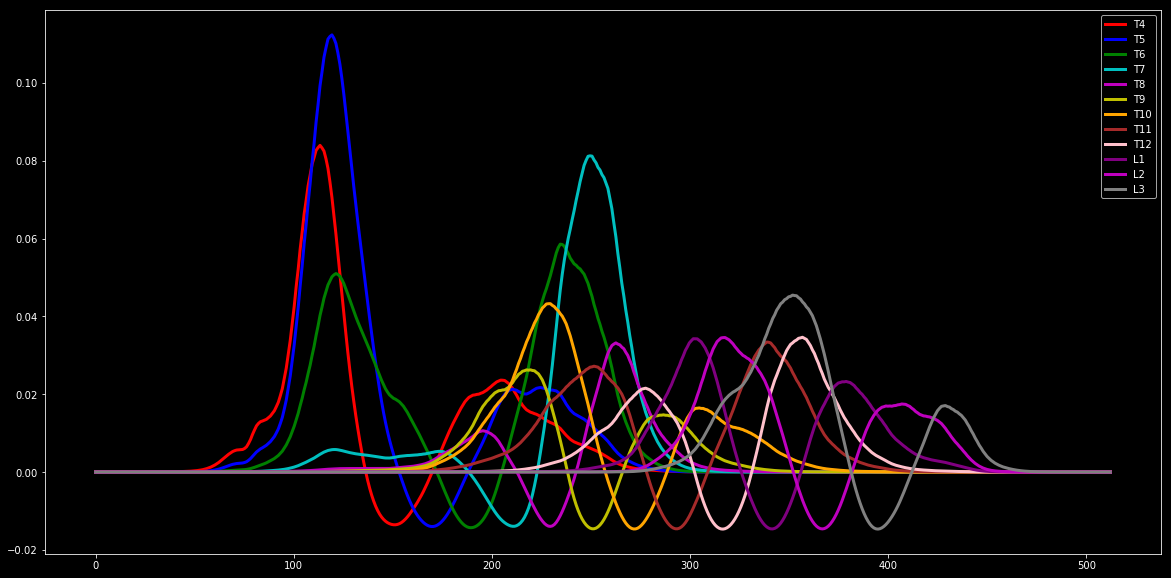

In [16]:
js_div(20)

# Down-weight neighbouring predictions

In [17]:
from scipy.special import softmax

In [18]:
def linear_expectation(probs, values):
    # Assumes normalised probs + single channel
    expectation = []
    for i in range(len(values)):
        expectation.append(probs[i]*values[i])
    return np.sum(expectation)

In [19]:
def update(p, q):
    #p = dist to update
    #q = prob not p
    combined = np.sum(q, axis=0)
    return p*(1-combined)

def down_weight(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_, dist.shape)
    eps=1e-24
    _, gt_targets, _ = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
#     ax[0].axhline(0, ls='--', c='w')
#     ax[1].axhline(0, ls='--', c='w')
    print(dist.shape)
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            norm_dist = dist/(dist.sum(axis=0, keepdims=True)+eps)
            tgt = gt_targets[:, 0, channel]
            idx = {idx: val for idx, val in enumerate(label)}
            neighbour_idx = [key for key, val in idx.items() if val ==1 and key !=channel]
            neigh = norm_dist[neighbour_idx]
            data = dist[channel]
            updated_data=dist[channel]*norm_dist[channel]**3
            updated_data = updated_data/np.sum(updated_data)
            mode = linear_expectation(data, x)

            updated_mode = linear_expectation(updated_data, x)
        
            ax[1].set_title('Updated predictions')
            ax[1].plot(x, tgt, alpha=0.8, lw=3, color=colors[channel], label=vert)
            ax[1].plot(x, updated_data, ls='--', alpha=0.8, lw=3, color=colors[channel])
            #ax[1].plot(x, data, alpha=0.8, lw=3, color=colors[channel])
            ax[1].axvline(updated_mode, color=colors[channel], lw=3)
            ax[0].set_title('Initial Predictions')
            ax[0].plot(x, data, ls='--', lw=3, color=colors[channel])
            ax[0].plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax[0].axvline(mode, color=colors[channel], lw=3, label=vert)

    ax[0].legend()
    ax[1].legend()
    #ax[1].set_ylim(ax[0].get_ylim())

fr_552_TS_Sag (13, 512)


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


(13, 512)


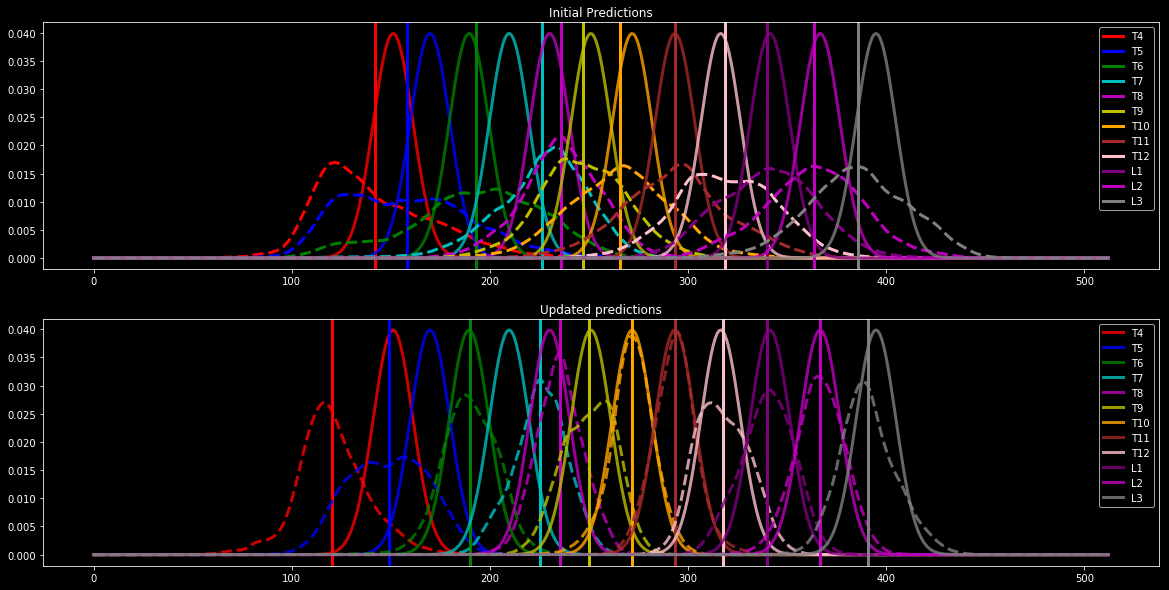

In [20]:
down_weight(20)

# Update predictions

In [21]:
def update_predictions(n):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_, dist.shape)
    eps=1e-24
    _, gt_targets, img = get_gt(id_)
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(img)
    norm_dist = []
    for i in range(dist.shape[1]):
        norm_dist.append(dist[:, i]/np.sum(dist[:, i]))
    norm_dist = np.array(norm_dist).T
    for channel in range(dist.shape[0]):
        vert = ordered_verts[channel]
        if label[channel] == 1:
            tgt = gt_targets[:, 0, channel]
            idx = {idx: val for idx, val in enumerate(label)}
            neighbour_idx = [key for key, val in idx.items() if val ==1 and key !=channel]
            neigh = norm_dist[neighbour_idx]
            data = dist[channel]
            mode = np.argmax(data)
            p = []
            for i in range(neigh.shape[0]):
                neg = neigh[i]
                p.append(neg)
            p = np.array(p)
            updated_data = update(data, p)
            updated_mode = np.argmax(updated_data)
            ax.set_title('Initial Predictions')
            
            ax.axhline(updated_mode, lw=3, ls='--', color=colors[channel])
            ax.text(1.05, updated_mode, vert, color='red')
            ax.axhline(mode, color=colors[channel], lw=3, label=vert)
            ax.text(0, mode, vert, color='white')
        
    #ax[1].set_ylim(ax[0].get_ylim())

fr_552_TS_Sag (13, 512)


,Level,Coordinate
0,T11,293.294724
1,L3,394.804426
2,L2,366.638028
3,T4,151.109913
4,T6,189.451719
5,T10,271.746855
6,T12,316.434050
7,L1,341.263380
8,T5,169.758460
9,T7,209.658530


/home/donal/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


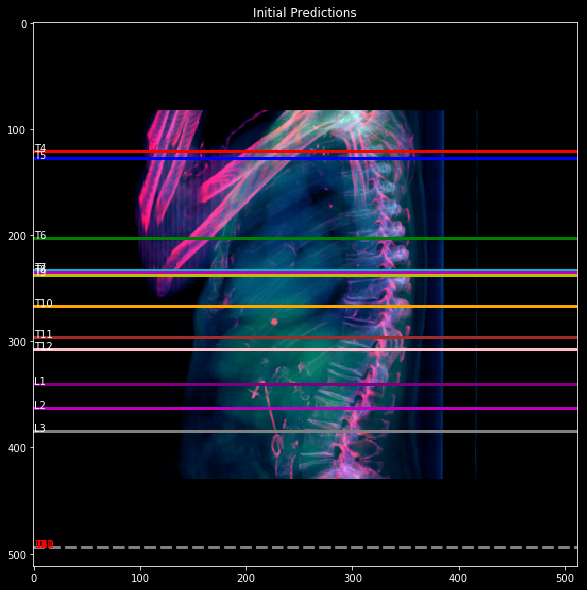

In [22]:
update_predictions(20)

# Update iteratively

In [23]:
def channel_norm(data):
    norm_data = []
    for i in range(data.shape[1]):
        norm_data.append(data[:, i]/np.sum(data[:, i]))
    return np.array(norm_data).T

def iter_update(n, num_iters=3):
    id_, coord, dist, label = ids[n], coords[n], dists[n, ..., 0], labels[n]
    print(id_)
    eps=1e-24
    _, gt_targets, img = get_gt(id_)
    
    x = np.linspace(0, dist.shape[-1], num=dist.shape[-1])
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    
    # Channel norm
    norm_dist = channel_norm(dist)
    all_data = dist
    
    modes = {0: np.argmax(dist, axis=1)}
    for k in range(1, num_iters+1):
        # Update predictions
        upd_data = []
        for channel in range(dist.shape[0]):
            vert = ordered_verts[channel]
            if label[channel] == 1:
                idx = {idx: val for idx, val in enumerate(label)}
                neighbour_idx = [key for key, val in idx.items() if val ==1 and key !=channel]
                neigh = norm_dist[neighbour_idx]
                data = all_data[channel]
                data = update(data, neigh)
                upd_data.append(data)
                
                
        all_data = np.array(upd_data)
        modes[k] =np.argmax(all_data, axis=1)
        norm_dist = channel_norm(all_data)
    for channel in range(norm_dist.shape[0]): 
        vert=ordered_verts[channel]
        if label[channel] == 1:
            updated_data = all_data[channel]
            data = dist[channel]
            tgt = gt_targets[:, 0, channel]
            ax[1].set_title('Updated predictions')
            ax[1].plot(x, tgt, alpha=0.8, lw=3, color=colors[channel], label=vert)
            ax[1].plot(x, updated_data, ls='--', alpha=0.8, lw=3, color=colors[channel])
            #ax[1].plot(x, data, alpha=0.8, lw=3, color=colors[channel])
            ax[1].axvline(modes[num_iters][channel], color=colors[channel], lw=3, label=vert)
            ax[0].set_title('Initial Predictions')
            ax[0].plot(x, data, ls='--', lw=3, color=colors[channel])
            ax[0].plot(x, tgt, alpha=0.8, lw=3, color=colors[channel])
            ax[0].axvline(modes[0][channel], color=colors[channel], lw=3, label=vert)
    ax[0].legend()
    ax[1].legend()
        
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(img)
    ax[1].imshow(img)
    for channel in range(norm_dist.shape[0]):
        vert=ordered_verts[channel] 
        if label[channel] == 1:
            ax[0].set_title('Initial Predictions') 
            ax[0].axhline(modes[0][channel], lw=3, color=colors[channel])
            ax[0].text(1.05, modes[0][channel], vert, color='white')
            ax[1].set_title('Updated Predictions')
            ax[1].axhline(modes[num_iters][channel], ls='--', color=colors[channel], lw=3, label=vert)
            ax[1].text(0, modes[num_iters][channel], vert, color='red')


28_05_2014_67_Sag


,Level,Coordinate
0,T9,252.813614
1,T4,155.613707
2,L1,349.582898
3,T5,173.198380
4,T7,211.306695
5,T12,323.535820
6,L3,403.673017
7,L2,376.183095
8,T10,275.281185
9,T6,191.829473


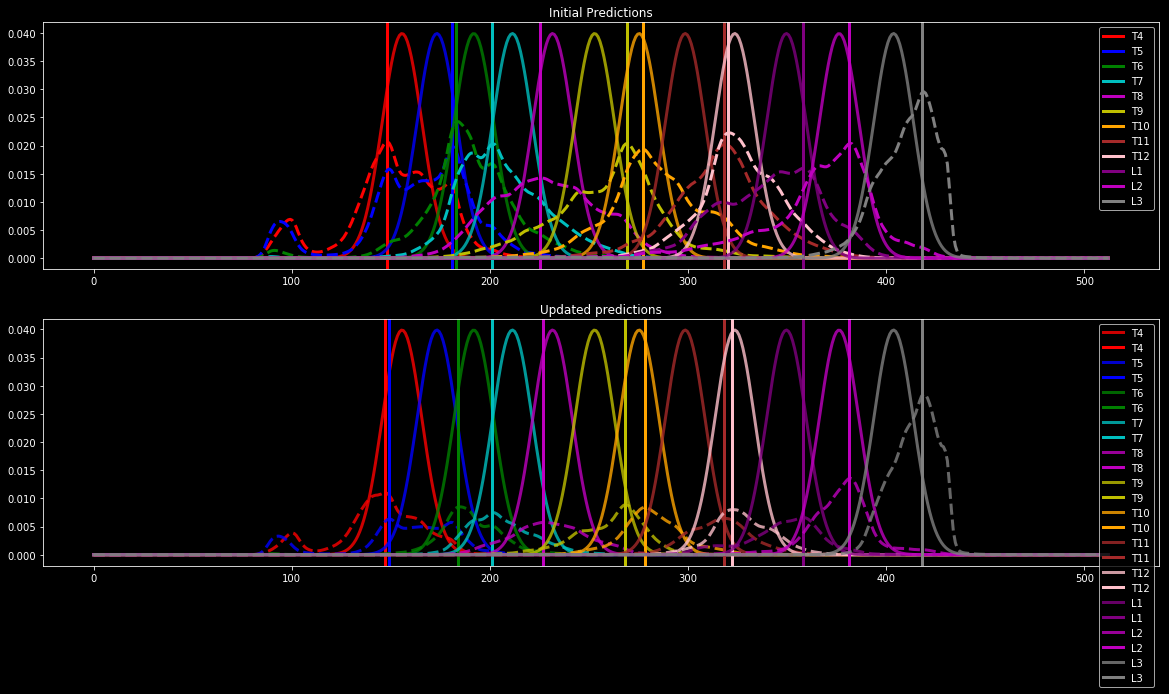

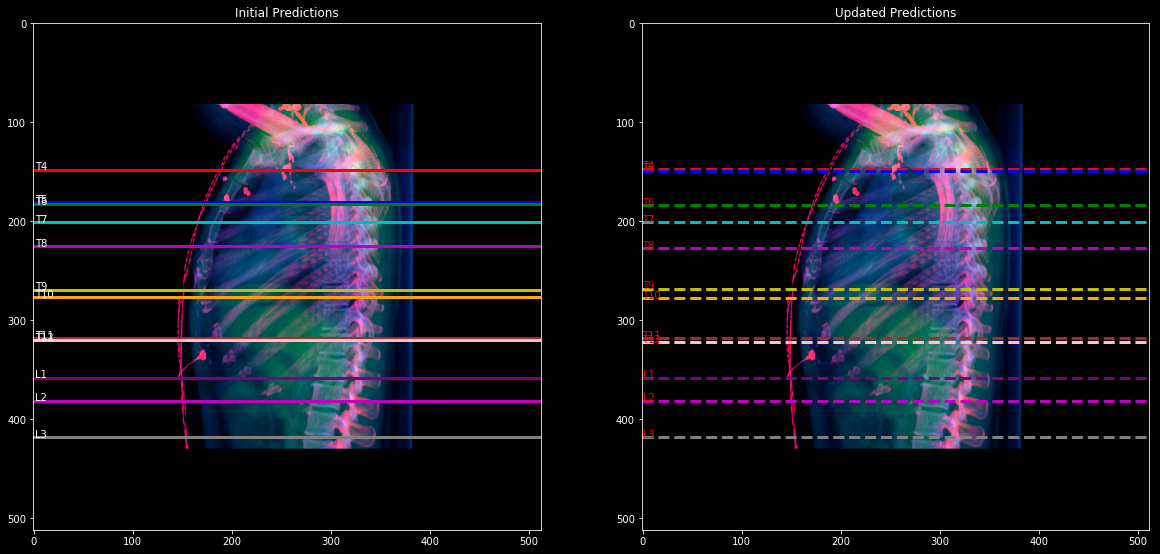

In [33]:
iter_update(23, num_iters=1)